# Librerías

In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from utils.datasets import (get_wine_dataset, get_iris_dataset, get_letters_dataset, 
                            get_penguins_dataset, label_encode, split_transpose)
from base.qda import QDA

# Función análisis

Se agrego al clasificador bayesiano del código base provisto una función para devolver el índice de clasificación junto con la probabilidad a posteriori de cada clase (para user solo en estos ejemplos). 

In [2]:
def plot_cm_auto_mpl(y_true, y_pred, labels=None, normalize=None,
                     cell_w=0.6, cell_h=0.6, min_w=3, min_h=3):
    """
    cell_w/cell_h: tamaño (en pulgadas) deseado por celda
    min_w/min_h: tamaño mínimo total de la figura
    normalize: None | 'true' (por fila) | 'pred' (por col) | 'all'
    labels: si es None, se usan los índices presentes en y_true/y_pred
    """
    # Si no hay class names, usar índices detectados en los datos
    if labels is None:
        labels_used = np.unique(np.r_[y_true, y_pred])  # ordenado
    else:
        labels_used = np.asarray(labels)

    # Calcular la matriz con el mismo orden de etiquetas
    cm = confusion_matrix(y_true, y_pred, labels=labels_used, normalize=normalize)
    n_rows, n_cols = cm.shape

    # Tamaño de figura proporcional al número de filas/columnas
    fig_w = max(min_w, cell_w * n_cols)
    fig_h = max(min_h, cell_h * n_rows)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    fmt = 'd' if normalize is None else '.2f'

    # Mostrar usando los mismos labels (como índices)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_used)
    disp.plot(ax=ax, values_format=fmt, colorbar=False)

    ax.set_aspect('equal', 'box')     # celdas lo más cuadradas posible
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def ejemplo_dataset(loader_func):

    # Carga

    X_full, y_full = loader_func()
    X_full.shape, y_full.shape

    print("- Analisis:")

    # Información básica

    n_obs, n_features = X_full.shape
    n_labels = np.unique(y_full).size 
    print(f"  Cantidad de muestras: {n_obs}")
    print(f"  Cantidad de características: {n_features}")
    print(f"  Cantidad de etiquetas: {n_labels}")
    unique_classes, counts = np.unique(y_full, return_counts=True)
    class_counts = dict(zip(unique_classes, counts))
    print("  Muestras por etiqueta:", class_counts)

    # Codifica etiquetas

    y_full_encoded = label_encode(y_full)

    # Separa train y test

    X_train, X_test, y_train, y_test = split_transpose(X_full, y_full_encoded, 0.300, 1265)

    # Crea clasificador

    qda = QDA()

    # Entrenamiento
    
    print("")
    print("- Entrenamiento:")

    print("  Formato X_train:", X_train.shape)
    print("  Formato y_train:", y_train.shape)

    qda.fit(X_train, y_train)

    print(f"  Cantidad log-prob a priori calculadas: {len(qda.log_a_priori)} {qda.log_a_priori[0].shape}")
    print(f"  Cantidad de vectores de medias calculados: {len(qda.means)} {qda.means[0].shape}")
    print(f"  Cantidad de matrices de covarianzas calculadas: {len(qda.inv_covs)} {qda.inv_covs[0].shape}")

    # Clasificacion

    print("")
    print("- Clasificación:")

    print("  Formato X_test:", X_test.shape)
    print("  Formato y_test:", y_test.shape)
    
    y_predict_with_probs = qda.predict_with_probs(X_test)

    y_pred_idx   = y_predict_with_probs[:, 0].astype(int)
    probs_mat    = y_predict_with_probs[:, 1:]

    y_true_idx = np.ravel(y_test).astype(int)

    acc = (y_pred_idx == y_true_idx).mean()
    print(f"  Precisión (accuracy): {acc:.3f} ({acc*100:.1f}%)")

    print("  Resultados:")
    for i, (pred_i, p) in enumerate(zip(y_pred_idx, probs_mat)):
        ok = (pred_i == y_true_idx[i])
        mark = "✓" if ok else f"<-- ERROR (true: {y_true_idx[i]}, pred: {pred_i})"
        print(f"{i:>5} -> clase: {pred_i:>2} | probs: " + " ".join(f"{x:.2f}" for x in p) + f"  {mark}")

    plot_cm_auto_mpl(y_true_idx, y_pred_idx)


# Dataset Wine
- Tipo / tamaño: 178 muestras, 13 características, 3 clases. 
- Características: alcohol, malic_acid, ash, alcalinity_of_ash, magnesium, total_phenols, flavanoids, nonflavanoid_phenols, proanthocyanins, color_intensity, hue, od280/od315_of_diluted_wines, proline.
- Clases: class_0, class_1, class_2. 
- Uso típico: clasificación multiclase, ejemplos de selección de variables y reducción de dimensión.

- Analisis:
  Cantidad de muestras: 178
  Cantidad de características: 13
  Cantidad de etiquetas: 3
  Muestras por etiqueta: {'class_0': 59, 'class_1': 71, 'class_2': 48}

- Entrenamiento:
  Formato X_train: (13, 124)
  Formato y_train: (1, 124)
  Cantidad log-prob a priori calculadas: 3 ()
  Cantidad de vectores de medias calculados: 3 (13, 1)
  Cantidad de matrices de covarianzas calculadas: 3 (13, 13)

- Clasificación:
  Formato X_test: (13, 54)
  Formato y_test: (1, 54)
  Precisión (accuracy): 0.981 (98.1%)
  Resultados:
    0 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    1 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    2 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    3 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    4 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    5 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    6 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    7 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    8 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    9 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
   10 ->

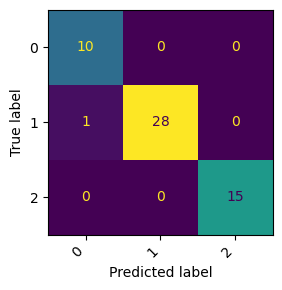

In [3]:
ejemplo_dataset(get_wine_dataset)

# Dataset Iris
- Tipo / tamaño: 150 muestras, 4 características, 3 clases. 
- Características: sepal length (cm), sepal width (cm), petal length (cm), petal width (cm). 
- Clases: setosa, versicolor, virginica. 
- Uso típico: clasificación multiclase, demos de PCA/LDA, superficies de decisión.

- Analisis:
  Cantidad de muestras: 150
  Cantidad de características: 4
  Cantidad de etiquetas: 3
  Muestras por etiqueta: {'setosa': 50, 'versicolor': 50, 'virginica': 50}

- Entrenamiento:
  Formato X_train: (4, 105)
  Formato y_train: (1, 105)
  Cantidad log-prob a priori calculadas: 3 ()
  Cantidad de vectores de medias calculados: 3 (4, 1)
  Cantidad de matrices de covarianzas calculadas: 3 (4, 4)

- Clasificación:
  Formato X_test: (4, 45)
  Formato y_test: (1, 45)
  Precisión (accuracy): 1.000 (100.0%)
  Resultados:
    0 -> clase:  1 | probs: 0.00 0.99 0.01  ✓
    1 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    2 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    3 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    4 -> clase:  2 | probs: 0.00 0.02 0.98  ✓
    5 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    6 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    7 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    8 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    9 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
   10 -> 

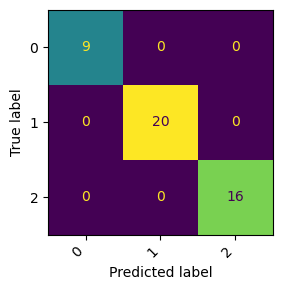

In [4]:
ejemplo_dataset(get_iris_dataset)

# Dataset Penguins
- Tipo / tamaño: 344 muestras, 6 características, 3 clases. 
- Características (simplificadas): island, bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g, sex (se descartan las no numericas en este caso). 
- Clases (species): Adelie, Chinstrap, Gentoo. 
- Uso típico: clasificación de especies; también regresión (p.ej., predecir masa corporal).

- Analisis:
  Cantidad de muestras: 342
  Cantidad de características: 4
  Cantidad de etiquetas: 3
  Muestras por etiqueta: {'Adelie': 151, 'Chinstrap': 68, 'Gentoo': 123}

- Entrenamiento:
  Formato X_train: (4, 239)
  Formato y_train: (1, 239)
  Cantidad log-prob a priori calculadas: 3 ()
  Cantidad de vectores de medias calculados: 3 (4, 1)
  Cantidad de matrices de covarianzas calculadas: 3 (4, 4)

- Clasificación:
  Formato X_test: (4, 103)
  Formato y_test: (1, 103)
  Precisión (accuracy): 0.990 (99.0%)
  Resultados:
    0 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    1 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    2 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    3 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    4 -> clase:  1 | probs: 0.00 1.00 0.00  ✓
    5 -> clase:  0 | probs: 1.00 0.00 0.00  ✓
    6 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    7 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    8 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
    9 -> clase:  2 | probs: 0.00 0.00 1.00  ✓
   10 -> c

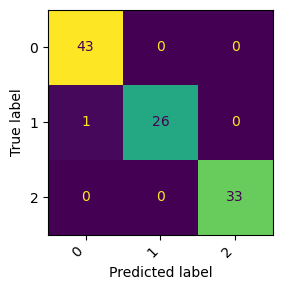

In [5]:
ejemplo_dataset(get_penguins_dataset)

# Dataset Letters
- Tipo / tamaño: 20 000 muestras, 16 características, 26 clases (A–Z). 
- Características (16): x-box, y-box, width, high, onpix, x-bar, y-bar, x2bar, y2bar, xybar, x2ybr, xy2br, x-ege, xegvy, y-ege, yegvx. 
- Clases: letras mayúsculas A…Z. 
- Uso típico: reconocimiento de caracteres/OCR con atributos “hand-crafted”.

- Analisis:
  Cantidad de muestras: 20000
  Cantidad de características: 16
  Cantidad de etiquetas: 26
  Muestras por etiqueta: {'A': 789, 'B': 766, 'C': 736, 'D': 805, 'E': 768, 'F': 775, 'G': 773, 'H': 734, 'I': 755, 'J': 747, 'K': 739, 'L': 761, 'M': 792, 'N': 783, 'O': 753, 'P': 803, 'Q': 783, 'R': 758, 'S': 748, 'T': 796, 'U': 813, 'V': 764, 'W': 752, 'X': 787, 'Y': 786, 'Z': 734}

- Entrenamiento:
  Formato X_train: (16, 14000)
  Formato y_train: (1, 14000)
  Cantidad log-prob a priori calculadas: 26 ()
  Cantidad de vectores de medias calculados: 26 (16, 1)
  Cantidad de matrices de covarianzas calculadas: 26 (16, 16)

- Clasificación:
  Formato X_test: (16, 6000)
  Formato y_test: (1, 6000)
  Precisión (accuracy): 0.894 (89.4%)
  Resultados:
    0 -> clase:  8 | probs: 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ✓
    1 -> clase: 20 | probs: 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 

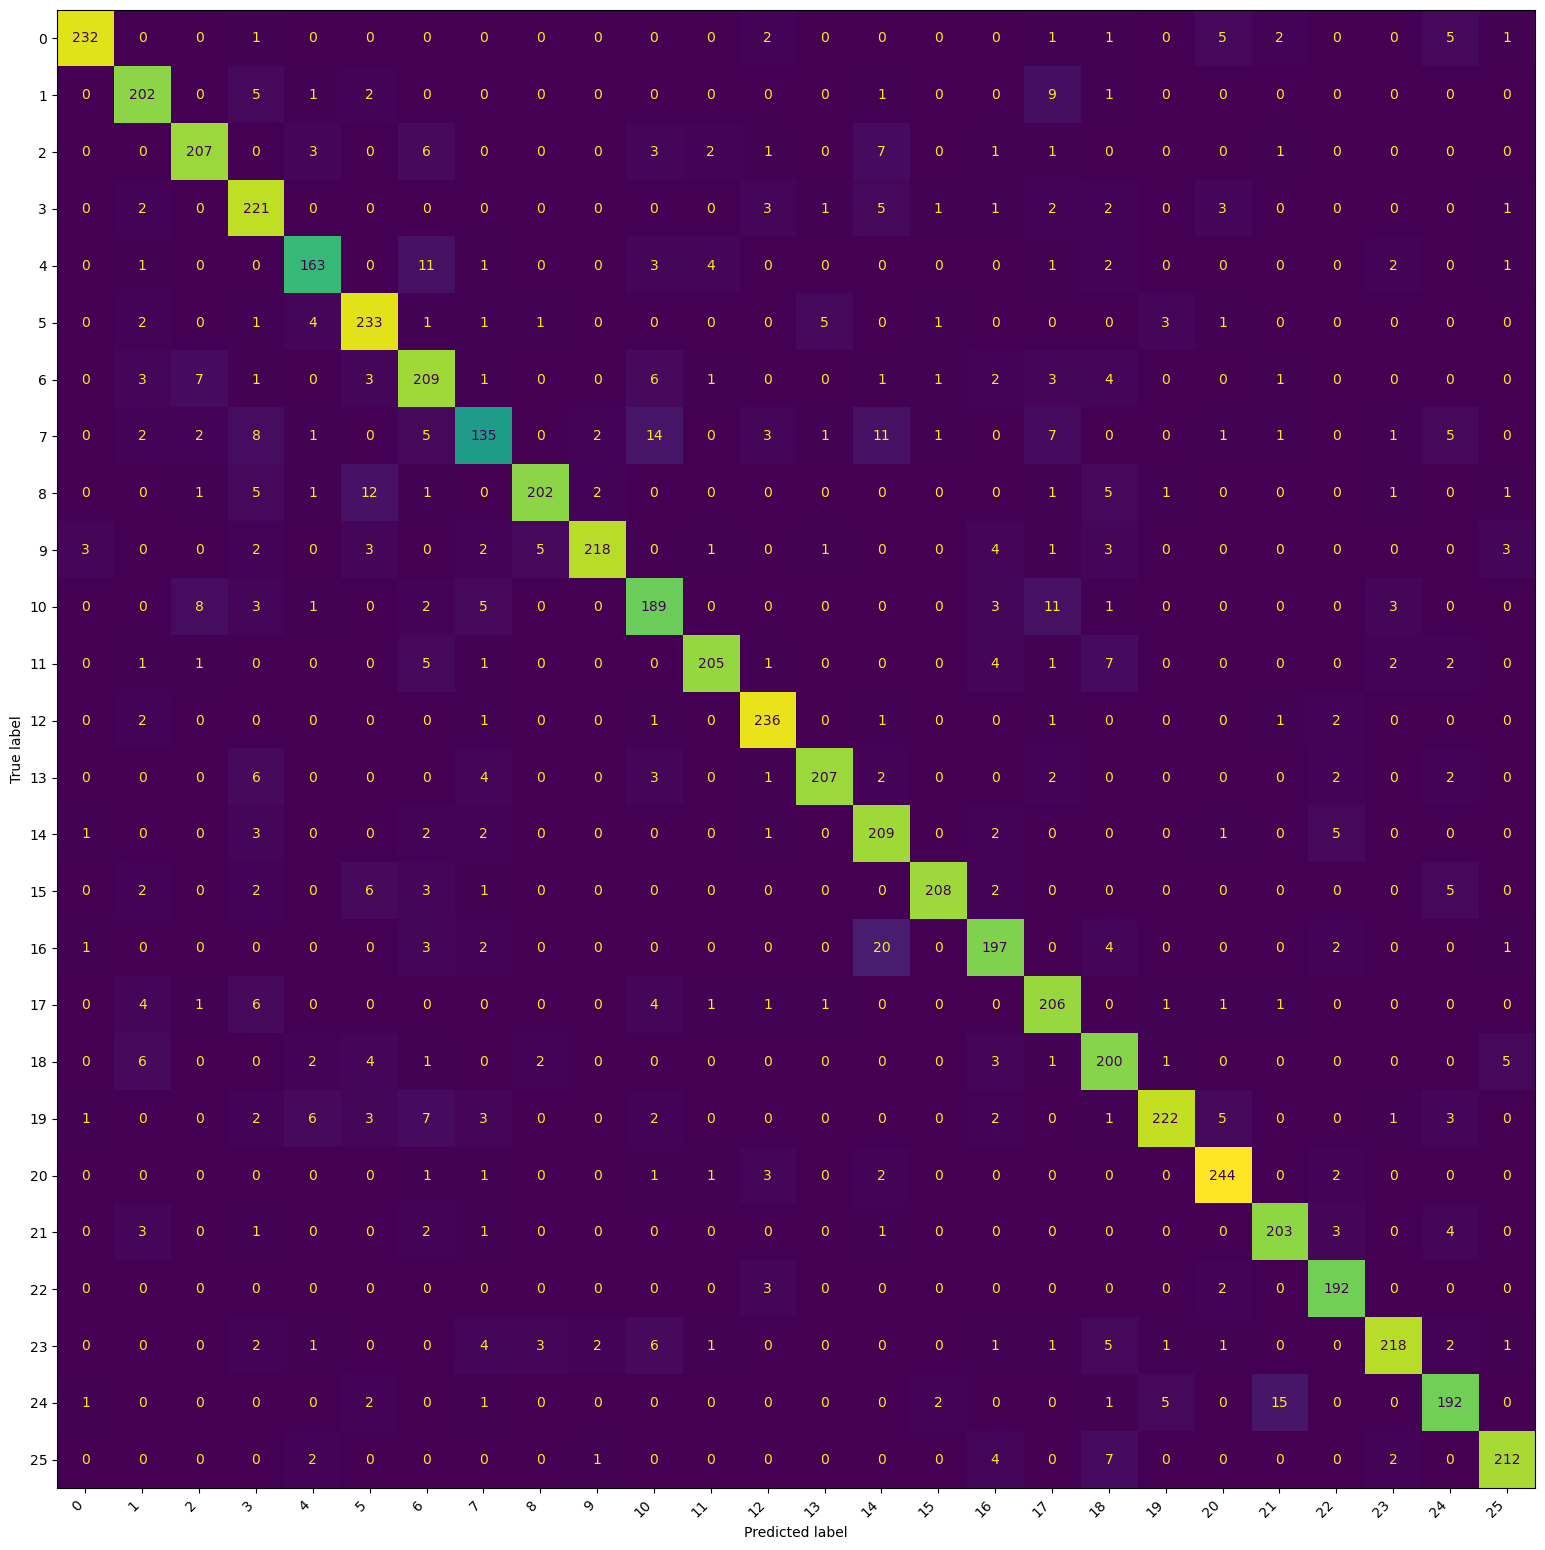

In [6]:
ejemplo_dataset(get_letters_dataset)